##ViT model Archirecture
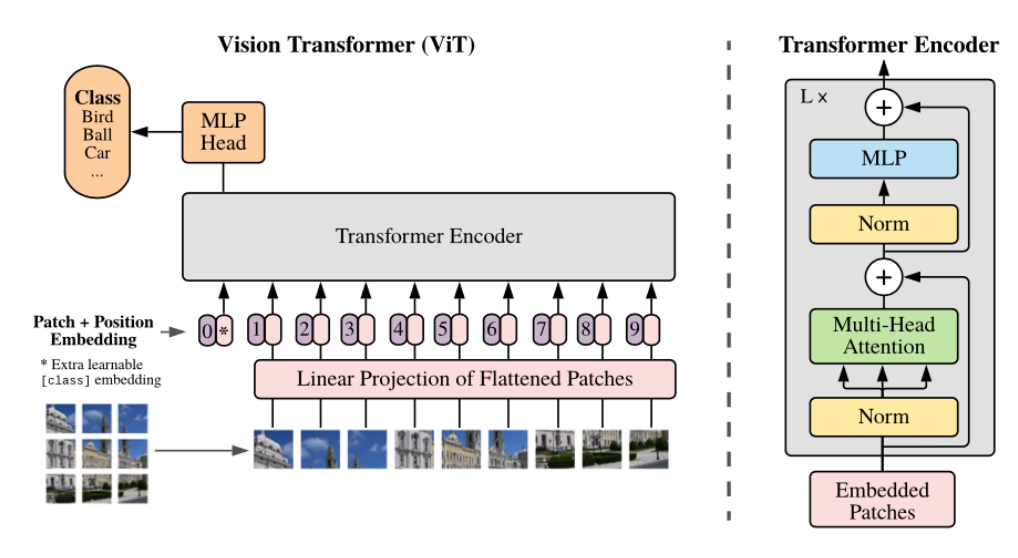

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Model Hyperparameters

In [ ]:
learning_rate = 0.001
num_epochs = 10



## 1.MLP

In [ ]:
'''
x: represents the input to the MLP.
hidden_units: is a list containing the number of units in each hidden layer.
dropout_rate: is the dropout rate, a regularization technique that randomly
 drops a proportion of connections during training to prevent overfitting.
'''
# Function to create MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x) #The activation function used is the GELU (Gaussian Error Linear Unit) activation
        x = layers.Dropout(dropout_rate)(x)
    return x

##2.Patch Creation Layer

In [ ]:
# creating patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],#sizes parameter defines the size of the patches to be extracted.
            strides=[1, self.patch_size, self.patch_size, 1],#strides parameter defines the step size between consecutive patch extractions.
            rates=[1, 1, 1, 1],#The rates parameter specifies dilation rates for extracting patches. In this case, it uses a dilation rate of 1 for all dimensions.
            padding='VALID', #padding parameter is set to 'VALID', meaning no padding is applied.
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


##3. Patch Encoding Layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim) #projection_dim. This layer is responsible for projecting the input patches to a different dimensionality.

        '''
        input_dim: is set to num_patches, indicating the number of possible positions.
        output_dim: is set to projection_dim, specifying the dimensionality of the embedding.
        '''
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

##4.Build the ViT model

In [ ]:
# Function to create Vision Transformer model
'''
image_size:
  The size of the input images.
num_classes:
  The number of output classes.
patch_size:
  The size of the patches to be extracted from the input images.
num_patches:
  The number of patches in the image.
projection_dim:
  The dimensionality of the projected patches.
num_heads:
  The number of attention heads in the Multi-Head Attention layer.
transformer_units:
   A list specifying the number of units in each transformer block.
num_blocks:
  The number of transformer blocks in the model.
mlp_head_units:
  A list specifying the number of units in the MLP head.
dropout_rate:
  The dropout rate used in the model. Default is set to 0.1.

'''
def vision_transformer(image_size, num_classes, patch_size, num_patches, projection_dim, num_heads, transformer_units, num_blocks, mlp_head_units, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(image_size, image_size, 3))

    # Patch extraction
    patches = tf.image.extract_patches(
        images=inputs,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )

    batch_size = tf.shape(patches)[0]
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])

    # Patch embedding and positional encoding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = layers.Dense(units=projection_dim)(patches) + layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)

    # Transformer blocks
    for _ in range(num_blocks):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)
        encoded_patches = layers.Add()([x3, x2])

    # Global average pooling
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)

    # MLP head
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout_rate)

    # Output layer
    logits = layers.Dense(num_classes, activation='softmax')(features)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=logits)

    return model

## preparing the Date

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.5,
    zoom_range=0.5,
    rotation_range=45,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True
)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_folder = r'/content/drive/MyDrive/dataset/test'

In [ ]:
train_generator = train_datagen.flow_from_directory(
    r"/content/drive/MyDrive/dataset/train",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True, subset='training'  # Shuffle the data
)

Found 9910 images belonging to 5 classes.


In [ ]:
# Get image filenames in the test folder
image_filenames = [os.path.join(test_folder, filename) for filename in os.listdir(test_folder) if filename.endswith(('.jpeg','.png'))]

In [ ]:
# Get image IDs
image_ids = [os.path.splitext(os.path.basename(filename))[0] for filename in image_filenames]

In [ ]:
# Create a DataFrame with test image paths
test_df = pd.DataFrame({
    'Image_ID': image_ids,
    'Image_Path': image_filenames
})

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Image_Path',  # Use 'Image_Path'
    y_col=None,  # No labels
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 100 validated image filenames.


## model configuration

In [ ]:
image_size = 224
num_classes = len(train_generator.class_indices)
patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]  # Size of the transformer layers
num_blocks = 8
mlp_head_units = [256, num_classes]
dropout_rate = 0.1


## create ViT model

In [ ]:
vit_model = vision_transformer(image_size, num_classes, patch_size, num_patches, projection_dim, num_heads, transformer_units, num_blocks, mlp_head_units, dropout_rate)

## Compile the Model

In [ ]:
# Compile the model
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

## model summary

In [ ]:
# Display the model summary
vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 14, 14, 768)  0          ['input_1[0][0]']                
 Lambda)                                                                                          
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (4,)                0           ['tf.image.extract_patches[0][0]'
 )                                                               ]                            

## train the model

In [ ]:
# Train the model
vit_model.fit(
    train_generator,
    epochs=1,
)

620/620 [==============================] - 1267s 2s/step - loss: 1.6097 - accuracy: 0.1921


In [ ]:
# Save the trained model
vit_model.save('vision_transformer_model.h5')